In [1]:

# Import libraries
import openai
from openai import OpenAI
import pandas as pd
import re
from datetime import datetime
from PyPDF2 import PdfReader


In [ ]:
# Replace with your actual OpenAI API key
client = OpenAI(api_key="YOUR_API_KEY")  # Paste your actual key here


In [3]:
# Load the PDF and extract text
pdf_path = "https___s3.us-east-2.amazonaws.com_sidearm.nextgen.sites_suathletics.com_documents_2025_2_10_2025SUStats.pdf_timestamp=20250512034310"
reader = PdfReader(pdf_path)

pdf_text = ""
for page in reader.pages:
    pdf_text += page.extract_text() + "\n"

print(pdf_text[:10000])  # Show the first 10000 characters to verify


2025 Syracuse Women's Lacrosse
Syracuse Combined Team Statistics
All games (as of May 12, 2025)
RECORD: OVERALL HOME AWAY NEUTRAL
ALL GAMES 10-9 5-4 4-4 1-1CONFERENCE 5-4 3-2 2-2 0-0NON-CONFERENCE 5-5 2-2 2-2 1-1
Date Opponent Score Att.
Feb 07 UALBANY W 21-9 2127
Feb 15 at #7 Maryland W 15-9 758
Feb 18 CORNELL W18-10 2214
*F e b  2 2 at #2 North Carolina  L 8-16 1088
Feb 25 #3 NORTHWESTERN  L 8-12 2080
*M a r  0 1 #14 CLEMSON  L 8-9 2899
*M a r  0 7 #7 STANFORD Wo214-13 2165
Mar 10 #10 JOHNS HOPKINS  L o t13-14 2049
*M a r  1 5 at Pitt W17-11 600
Mar 19 at #17 Loyola W14-12 432
*M a r  2 3 #20 NOTRE DAME W12-11 3622
*M a r  2 9 #11 VIRGINIA W13-12 2736
Apr 02 at #13 Yale Bulldogs  L10-13 653
*A p r  0 5 at California W 18-6 250
*A p r  1 2 at Virginia Tech  L11-14 157
*A p r  1 7 #2 BOSTON COLLEGE  L 2-17 1645
Apr 22 vs #13 Stanford  L10-15 0
May 09 vs Brown Bears W 15-9 583
May 11 at #5 Yale Bulldogs  L 8-9 608
TEAM STATISTICS SU OPP
  Neutral Site #/Avg 2/292Goals by Period 1st 2nd 

In [4]:
lines = pdf_text.split("\n")
months = {"Feb", "Mar", "Apr", "May"}

# Show all lines that start with month
for line in lines:
    if any(line.startswith(month) for month in months):
        print(repr(line))  # Show escaped characters like \n

structured_games = []
months = {"Jan", "Feb", "Mar", "Apr", "May"}

for line in lines:
    if any(line.startswith(month) for month in months):
        try:
            # Extract date
            parts = line.strip().split()
            month, day = parts[0], parts[1]
            game_date = datetime.strptime(f"{month} {day} 2025", "%b %d %Y")

            # Extract attendance
            attendance_match = re.search(r"(\d+)\s*$", line)
            attendance = int(attendance_match.group(1)) if attendance_match else None

            # Normalize spacing
            line = line.replace("o t", "ot").replace("o  t", "ot")

            # Final flexible result+score regex
            result_score_match = re.search(r"\b(W|L)\s*(ot)?\s*(\d+)-(\d+)", line)
            if not result_score_match:
                raise ValueError("No result/score found")

            result = result_score_match.group(1)
            if result_score_match.group(2):
                result += "ot"
            su_score = int(result_score_match.group(3))
            opp_score = int(result_score_match.group(4))

            # Extract opponent
            start_index = line.find(day) + len(day)
            end_index = result_score_match.start()
            opponent = line[start_index:end_index].strip()

            structured_games.append({
                "Date": game_date.strftime("%Y-%m-%d"),
                "Opponent": opponent,
                "Result": result,
                "SU_Score": su_score,
                "Opponent_Score": opp_score,
                "Attendance": attendance
            })

        except Exception as e:
            print(f" Could not parse line: {line} | Error: {e}")

print(f"Parsed {len(structured_games)} games.")


'Feb 07 UALBANY W 21-9 2127'
'Feb 15 at #7 Maryland W 15-9 758'
'Feb 18 CORNELL W18-10 2214'
'Feb 25 #3 NORTHWESTERN  L 8-12 2080'
'Mar 10 #10 JOHNS HOPKINS  L o t13-14 2049'
'Mar 19 at #17 Loyola W14-12 432'
'Apr 02 at #13 Yale Bulldogs  L10-13 653'
'Apr 22 vs #13 Stanford  L10-15 0'
'May 09 vs Brown Bears W 15-9 583'
'May 11 at #5 Yale Bulldogs  L 8-9 608'
Parsed 10 games.


In [5]:
df = pd.DataFrame(structured_games)
df.head(10)


,Date,Opponent,Result,SU_Score,Opponent_Score,Attendance
0,2025-02-07,UALBANY,W,21,9,2127
1,2025-02-15,at #7 Maryland,W,15,9,758
2,2025-02-18,CORNELL,W,18,10,2214
3,2025-02-25,#3 NORTHWESTERN,L,8,12,2080
4,2025-03-10,#10 JOHNS HOPKINS,Lot,13,14,2049
5,2025-03-19,at #17 Loyola,W,14,12,432
6,2025-04-02,at #13 Yale Bulldogs,L,10,13,653
7,2025-04-22,vs #13 Stanford,L,10,15,0
8,2025-05-09,vs Brown Bears,W,15,9,583
9,2025-05-11,at #5 Yale Bulldogs,L,8,9,608


In [6]:
df.to_csv("syracuse_w_lacrosse_2025.csv", index=False)
print("CSV saved.")

CSV saved.


In [7]:
sample_data = df.head(10).to_string(index=False)
print(sample_data)

      Date             Opponent Result  SU_Score  Opponent_Score  Attendance
2025-02-07              UALBANY      W        21               9        2127
2025-02-15       at #7 Maryland      W        15               9         758
2025-02-18              CORNELL      W        18              10        2214
2025-02-25      #3 NORTHWESTERN      L         8              12        2080
2025-03-10    #10 JOHNS HOPKINS    Lot        13              14        2049
2025-03-19        at #17 Loyola      W        14              12         432
2025-04-02 at #13 Yale Bulldogs      L        10              13         653
2025-04-22      vs #13 Stanford      L        10              15           0
2025-05-09       vs Brown Bears      W        15               9         583
2025-05-11  at #5 Yale Bulldogs      L         8               9         608


In [8]:
questions = [
    "How many games did Syracuse Women’s Lacrosse play in 2025?",
    "What is their win/loss record?",
    "Which game had the highest attendance?",
    "What was their average goal score?",
    "Which game was the closest by goal margin?"
]


In [9]:
def ask_chatgpt(question, context=None):
    prompt = f"""
    You are analyzing Syracuse Women's Lacrosse 2025 season data.
    Here is a sample of the dataset:

    {context}

    Now answer the following question:
    {question}
    """

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful data analyst."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.3
    )

    return response.choices[0].message.content.strip()


In [10]:
for q in questions:
    print(f"\n Question: {q}")
    try:
        answer = ask_chatgpt(q, context=sample_data)
        print(f" Answer: {answer}")
    except Exception as e:
        print(f" Error: {e}")



 Question: How many games did Syracuse Women’s Lacrosse play in 2025?
 Answer: Syracuse Women's Lacrosse played a total of 10 games in the 2025 season.

 Question: What is their win/loss record?
 Answer: To determine the win/loss record for Syracuse Women's Lacrosse in the 2025 season, we need to count the number of wins and losses from the provided data.

From the sample dataset:
- Wins: 6 (against UALBANY, Maryland, Cornell, Loyola, Brown Bears)
- Losses: 3 (against Northwestern, Johns Hopkins, Yale Bulldogs)

Therefore, Syracuse Women's Lacrosse had a win-loss record of 6-3 in the 2025 season.

 Question: Which game had the highest attendance?
 Answer: The game with the highest attendance was the match against Cornell on February 18th, 2025, with an attendance of 2214.

 Question: What was their average goal score?
 Answer: To calculate the average goal score for Syracuse Women's Lacrosse team in the 2025 season, we need to sum up all the SU_Score values and then divide by the tota

Data Visualization using LLM

In [11]:
def ask_for_plot(question, context):
    prompt = f"""
You are a helpful data scientist. Below is a sample of Syracuse Women's Lacrosse 2025 dataset:

{context}

Now write Python code using matplotlib that will answer the following question through a chart or visualization:

{question}
"""
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You generate Python data visualizations using matplotlib."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.2
    )
    return response.choices[0].message.content.strip()


In [12]:
def extract_code_blocks(text):
    import re
    # Look for code in triple backticks (```)
    code_blocks = re.findall(r"```(?:python)?\n(.*?)```", text, re.DOTALL)
    return "\n".join(code_blocks).strip() if code_blocks else text.strip()


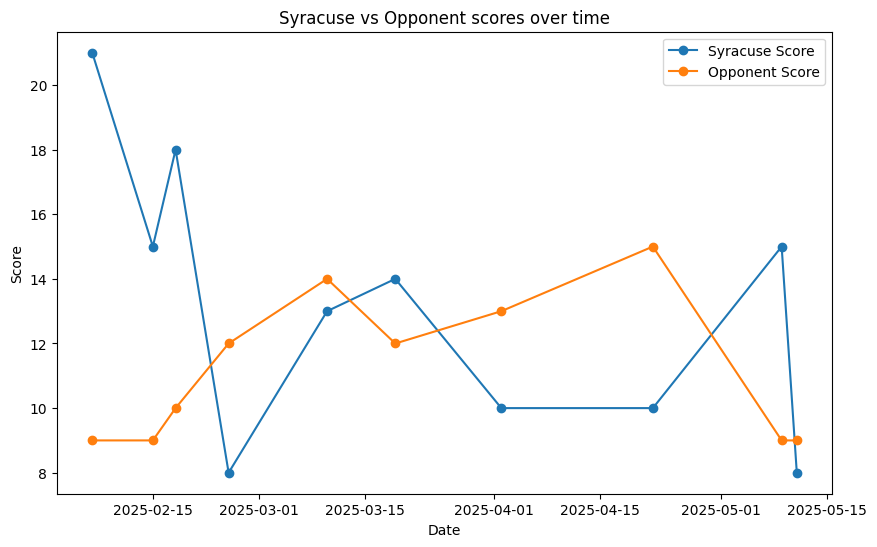

In [ ]:
# Ask LLM to generate visualization code
viz_question = "Plot Syracuse vs Opponent scores over time"
code_response = ask_for_plot(viz_question, context=sample_data)

# Extract just the code block
clean_code = extract_code_blocks(code_response)

# Replace file reading line with actual in-memory DataFrame
clean_code = clean_code.replace("pd.read_csv('data.csv')", "df.copy()")
clean_code = clean_code.replace('pd.read_csv("data.csv")', "df.copy()")  # just in case double quotes



exec(clean_code)
